This notebook will be used to write code and investigate the accuracy of rank 1 tensor approximations using HOSVD?

In [36]:
using Plots
using Makie
using GraphMakie.NetworkLayout
using CairoMakie
using Tenet
using TensorOperations
using LinearAlgebra
using EinExprs
using Combinatorics
using LaTeXStrings
Makie.inline!(true)
include("julia_functions.jl")

generate_combinations (generic function with 1 method)

This function takes in a Tenet.Tensor and computes the best rank-one-approximation for this specific tensor.
The best rank-one-approximation is defined is $T_{ijkl} = \Omega U^i \otimes U^j \otimes U^k \otimes U^l$. The functions return all the vectors $U^{index}$ and the constant $\Omega$.

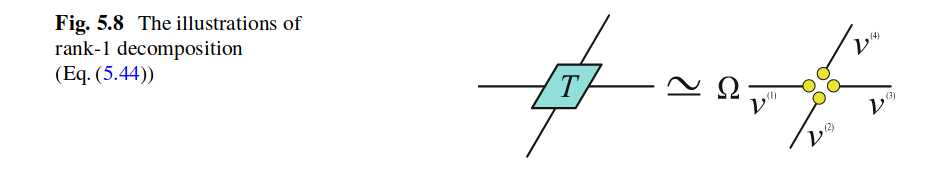

In [37]:
test = Tenet.Tensor(rand(3,3,3), (Symbol("i"), Symbol("j"), Symbol("k")))

function matricisation_fold(Tensor, index)


    #TODO unfolding aanpassen aan definitie paper

    """
    Function takes in a Tenet.Tensor and computes its folded version.
    i.e. A Matricization such that the Tensor is restructured as A{index}{prod all indices} with a new symbol as the concatenated string of all indices
    """ 

    # Compute the dimension of the new bond -> this new bond has the size of the product of the grouped dimensions

    indices = inds(Tensor) # all indices of the Tensor
    to_group = setdiff(inds(Tensor), [index])
    dim_new = prod(size(Tensor, index) for index in to_group) # compute the dimension of the new grouped bond
    
    # generate a permutation order of indices which puts the to group indices in the end
    # by reshaping the underlying data array -> (dim(complementind_T1)..., dim_new) the correct parts of the data array are grouped

    new_order = [[index]..., to_group...] # indices to keep at front

    # Permute the dimensions based on the new order
    permuted_tensor = permutedims(Tensor, new_order)

    # extract the permuted tensor data to be reshaped
    new_tensor_data_array = permuted_tensor.data

    # perform the reshaping and create new tensors with grouped index
    new_index = join([string(ix) for ix in to_group], "")

    # create reshape lists -> casted to tuple for the reshape function
    # reshape lists are based on sizes of the underlying data arrays
    # vcat vertically concatenates two arrays

    tensor_reshape_list = vcat([size(Tensor, index)], dim_new)

    # Create the new tensors based on the the reshaped data array and on a tuple containing the untouched indices and the newly grouped index

    tensor_new = Tenet.Tensor(reshape(new_tensor_data_array, tensor_reshape_list...), ([index]..., Symbol(new_index)))

    return tensor_new

end

function extract_dominant_left_singular_vector(M)
    """
    Input is a matrix M and output is the dominant left singular vector. This is the vector corresponding to biggest singular value.
    """
    U, s, Vt = LinearAlgebra.svd(M)
    return U[:, 1]

end

function extract_initial_vectors(Tensor)
    initial_vectors = []
    indices = inds(Tensor)
    for index in indices[2:end]
        folded = matricisation_fold(Tensor, index)
        display(folded.data)
        push!(initial_vectors, extract_dominant_left_singular_vector((folded).data))
    end
    return initial_vectors 
end

display(extract_initial_vectors(test))

function compute_tensor_product(vectors)

    """
    Helper product to compute the Kronecker product for a list of vectors
    """

    num_vectors = length(vectors)

    # Check if there are at least two vectors for the tensor product
    @assert num_vectors >= 2

    # Initialize the result with the tensor product of the first two vectors
    result = outer(vectors[1], vectors[2])

    # Compute the tensor product with the remaining vectors
    for i in 3:num_vectors
        result = outer(result, vectors[i])
    end

    return result
end


function compute_rank_one_approximation(Tensor, eps, max_iter)
    optimized_output_vectors = []
    indices = inds(Tensor)
    start_vectors = extract_initial_vectors(Tensor)

    U_old = nothing  # Initialize U_old and lambda_old
    lambda_old = nothing
    U_new = nothing   # Initialize U_new and lambda_new
    lambda_new = nothing

    for (i, index) in enumerate(indices)
        A_i_fold = matricisation_fold(Tensor, index).data

        for step in 1:max_iter
            if i == 1 && step == 1
                println("Initialization")
                U_old = compute_tensor_product(start_vectors)
                lambda_old = LinearAlgebra.norm(U_old)
            end

            if i > 1
                println("Computing tensor product without vector i")
                U_old = compute_tensor_product([optimized_output_vectors..., start_vectors[i+1:end]...])
            end

            if step > 1
                U_old = U_new  # Initialize U_old for the next iteration
                lambda_old = lambda_new
            end
            println(size(A_i_fold), size(U_old))
            U_new = A_i_fold * U_old
            lambda_new = LinearAlgebra.norm(U_new)
            U_new = U_new / lambda_new
            error = abs(lambda_new - lambda_old)

            if error < eps
                push!(optimized_output_vectors, U_new)
                break
            end

            if step == max_iter
                push!(optimized_output_vectors, U_new)
                break
            end
        end
    end

    U_final = compute_tensor_product(optimized_output_vectors)
    lambda_final = Tensor.data' * U_final  # Assuming you want to perform matrix-vector multiplication

    return (optimized_output_vectors, lambda_final)
end

compute_rank_one_approximation(test, 1e-5, 100)

compute_rank_one_approximation(test, 1e-5, 100)



3×9 Matrix{Float64}:
 0.146231  0.864381  0.303197  0.201586    …  0.915054  0.324804   0.34304
 0.478043  0.248756  0.869934  0.00384605     0.437162  0.0466071  0.788221
 0.504597  0.421195  0.89619   0.992449       0.976519  0.946167   0.0516434

3×9 Matrix{Float64}:
 0.146231  0.864381  0.303197  0.478043    …  0.504597  0.421195   0.89619
 0.201586  0.463168  0.827692  0.00384605     0.992449  0.0429554  0.647163
 0.915054  0.324804  0.34304   0.437162       0.976519  0.946167   0.0516434

2-element Vector{Any}:
 [-0.5405567880205514, -0.49174420221860066, -0.6826316711882743]
 [-0.5664447721101489, -0.5745225107693719, -0.5908165576287947]

3×9 Matrix{Float64}:
 0.146231  0.864381  0.303197  0.201586    …  0.915054  0.324804   0.34304
 0.478043  0.248756  0.869934  0.00384605     0.437162  0.0466071  0.788221
 0.504597  0.421195  0.89619   0.992449       0.976519  0.946167   0.0516434

3×9 Matrix{Float64}:
 0.146231  0.864381  0.303197  0.478043    …  0.504597  0.421195   0.89619
 0.201586  0.463168  0.827692  0.00384605     0.992449  0.0429554  0.647163
 0.915054  0.324804  0.34304   0.437162       0.976519  0.946167   0.0516434

Initialization


UndefVarError: UndefVarError: `outer` not defined